<a href="https://colab.research.google.com/github/emreozeren/Uskudar_Unv_YSA/blob/main/Yapay_Sinir_Aglari_234329046_Emre_Ozeren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Gerekli Kutuphanelerin Yuklenmesi

In [ ]:
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import random
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### 2. Veri Seti Yukleme ve On Isleme

#### 2.1. Veri Yukleme

In [ ]:
# Veriyi modele uydurma transformu
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

# Veri setini indirme
train_dataset = torchvision.datasets.GTSRB(
    root='./data', split='train', download=True, transform=transform)

# Veriyi DataFrame'e dönüştürme
data_list = []

for img, label in train_dataset:
    data_list.append((img.numpy().flatten(), label))

# DataFrame olusturuma
df = pd.DataFrame(data_list, columns=['features', 'label'])

# Cikti olusturma
print(df.head())

100%|██████████| 187M/187M [00:01<00:00, 154MB/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb
                                            features  label
0  [0.29411766, 0.2901961, 0.3254902, 0.39607844,...      0
1  [0.27058825, 0.29411766, 0.29411766, 0.3019608...      0
2  [0.28235295, 0.30588236, 0.30588236, 0.4470588...      0
3  [0.26666668, 0.29803923, 0.34901962, 0.5529412...      0
4  [0.28627452, 0.2901961, 0.29411766, 0.43529412...      0


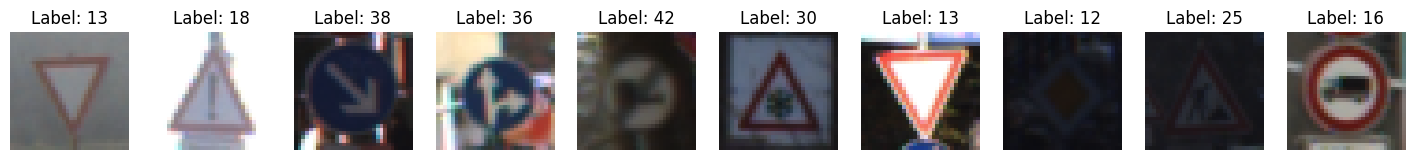

In [ ]:
# 10 random goruntu gosterme
num_images_to_show = 10
random_indices = random.sample(range(len(train_dataset)), num_images_to_show)

fig, axes = plt.subplots(1, num_images_to_show, figsize=(18, 5))

for i, index in enumerate(random_indices):
  image, label = train_dataset[index]
  axes[i].imshow(np.transpose(image.numpy(), (1, 2, 0)))
  axes[i].set_title(f"Label: {label}")
  axes[i].axis('off')

plt.show()

In [ ]:
print(train_dataset)

Dataset GTSRB
    Number of datapoints: 26640
    Root location: ./data
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


#### 2.2. Eksik Degerlerin Islenmesi

In [ ]:
print(df.isnull().sum())

# Eksik degerleri mode ile doldurma

for index, row in df.iterrows():
    if pd.isnull(row['features']).any():  # Dizide herhangi bir eksik değer var mı?
        # df.loc[index, 'features'] = np.nan_to_num(row['features'],
        # fill_value=0)
        df['label'] = df['label'].fillna(df['label'].mode()[0])

# Eksik degerleri kontrol etme
print('Mode ile doldurma sonrası')
print(df.isnull().sum())

features    0
label       0
dtype: int64
Mode ile doldurma sonrası
features    0
label       0
dtype: int64


#### 2.3. Veri Setini Eğitim ve Test Olarak Ayrıma

In [ ]:
# Ozellik matrisi (X) ve hedef degisken (y) olusturma
X = np.stack(df['features'].values)
y = df['label'].values

# Veriyi egitim ve test kumelerine ayirma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sonuclari gosterme
print("Eğitim kümesi boyutu:", X_train.shape)
print("Test kümesi boyutu:", X_test.shape)

Eğitim kümesi boyutu: (21312, 3072)
Test kümesi boyutu: (5328, 3072)


#### 2.4. Ozellik Olcekleme (Feature Scaling)

In [ ]:
# Standartlastirma icin StandardScaler kullanma
scaler = StandardScaler()
X_train_StandartScaler = scaler.fit_transform(X_train)
X_test_StandartScaler = scaler.transform(X_test)

np.set_printoptions(linewidth=200)
# Standartlastirilmis verileri gosterme
print("Standartlaştırılmış eğitim verileri:\n", X_train_StandartScaler[:5])
print("Standartlaştırılmış test verileri:\n", X_test_StandartScaler[:5])

Standartlaştırılmış eğitim verileri:
 [[ 0.75200784  0.72539014  0.71891266 ...  1.5014181   1.5020005   1.4908231 ]
 [-0.76304746 -0.780099   -0.7829499  ... -0.10837136 -0.02125802  0.04274715]
 [ 0.12508838  0.26719776  0.48383856 ...  2.923659    2.9467404   2.9233284 ]
 [-0.78916913 -0.8586462  -0.86130786 ... -0.6241292  -0.6179985  -0.6112226 ]
 [-0.67162174 -0.5968221  -0.62623376 ... -0.54598397 -0.53948003 -0.5956519 ]]
Standartlaştırılmış test verileri:
 [[-0.37122285 -0.780099   -0.87436754 ... -0.530355   -0.2411098   0.94584835]
 [-0.9850814  -0.97646713 -0.9919046  ... -0.10837136 -0.13118394 -0.15967211]
 [-0.14918885 -0.11244728 -0.14302585 ... -0.5147259  -0.5080726  -0.47108626]
 [ 1.979725    1.9559639   1.8159251  ...  0.5167896   0.49696392  0.47872698]
 [-0.86753404 -0.8324638  -0.8221289  ... -0.6553872  -0.68081325 -0.6579348 ]]


In [ ]:
# Standartlastirma icin MinMaxScaler kullanma
scaler = MinMaxScaler()
X_train_MinMaxScaler = scaler.fit_transform(X_train)
X_test_MinMaxScaler = scaler.transform(X_test)

# Olceklendirilmis verileri gosterme
print("MinMaxScaler ile ölçeklendirilmiş eğitim verileri:\n", X_train_MinMaxScaler[:5])
print("MinMaxScaler ile ölçeklendirilmiş test verileri:\n", X_test_MinMaxScaler[:5])

MinMaxScaler ile ölçeklendirilmiş eğitim verileri:
 [[0.572      0.564      0.564      ... 0.6345382  0.63052213 0.6392157 ]
 [0.10800001 0.104      0.104      ... 0.22088353 0.24096386 0.27450982]
 [0.38       0.424      0.492      ... 1.         1.         1.        ]
 [0.09999999 0.08       0.08       ... 0.08835341 0.08835341 0.10980392]
 [0.136      0.16000001 0.15200001 ... 0.10843374 0.10843374 0.11372549]]
MinMaxScaler ile ölçeklendirilmiş test verileri:
 [[0.228      0.104      0.07600001 ... 0.11244981 0.18473895 0.5019608 ]
 [0.04       0.044      0.04       ... 0.22088353 0.2128514  0.22352941]
 [0.296      0.308      0.29999998 ... 0.11646587 0.11646587 0.14509805]
 [0.948      0.94       0.90000004 ... 0.38152608 0.37349397 0.38431373]
 [0.07600001 0.088      0.09199999 ... 0.08032128 0.07228916 0.09803922]]


### 3.Model Egitimi ve Hiperparametre Denemeleri

#### 3.1. MLP Modeli

##### 3.1. MLP Modeli Min-Max Scaler

In [ ]:
# MinMaxScaler ile olceklendirilmis verileri kullanarak MLP modelini olusturma
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50),
                          max_iter=100,
                          alpha=0.0001,
                          solver='adam',
                          verbose=10,
                          random_state=21,
                          tol=0.000000001)

# Modeli egitme
mlp_model.fit(X_train_MinMaxScaler, y_train)

# Test verileri uzerinde tahmin yapma
y_pred_minmax = mlp_model.predict(X_test_MinMaxScaler)

# Sonuclari degerlendirme
print(classification_report(y_test, y_pred_minmax))
print(confusion_matrix(y_test, y_pred_minmax))

Iteration 1, loss = 2.97457005
Iteration 2, loss = 1.93589746
Iteration 3, loss = 1.42608883
Iteration 4, loss = 1.12311248
Iteration 5, loss = 0.93510876
Iteration 6, loss = 0.78481542
Iteration 7, loss = 0.69032608
Iteration 8, loss = 0.59905744
Iteration 9, loss = 0.55262710
Iteration 10, loss = 0.49353824
Iteration 11, loss = 0.45228538
Iteration 12, loss = 0.41669932
Iteration 13, loss = 0.38893821
Iteration 14, loss = 0.38206770
Iteration 15, loss = 0.35015193
Iteration 16, loss = 0.32645620
Iteration 17, loss = 0.29847746
Iteration 18, loss = 0.29119711
Iteration 19, loss = 0.27655832
Iteration 20, loss = 0.27493665
Iteration 21, loss = 0.26355867
Iteration 22, loss = 0.24912377
Iteration 23, loss = 0.24941941
Iteration 24, loss = 0.23594669
Iteration 25, loss = 0.21337272
Iteration 26, loss = 0.21212670
Iteration 27, loss = 0.21705919
Iteration 28, loss = 0.20902709
Iteration 29, loss = 0.20450166
Iteration 30, loss = 0.18750300
Iteration 31, loss = 0.17723617
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


##### 3.1. MLP Modeli Min-Max Scaler Farklı Hiperparametreler

In [ ]:
# MLP modelini farkli parametrelerle olusturma
mlp_model = MLPClassifier(
    hidden_layer_sizes=(50, 25),  # Gizli katman boyutlari degistirme
    activation='relu',  # Aktivasyon fonksiyonu degistirme (relu, tanh, logistic)
    solver='sgd',  # Optimizasyon algoritmasi degistirme (adam, lbfgs, sgd)
    learning_rate='adaptive',  # Ogrenme orani stratejisi degistirme (constant, invscaling, adaptive)
    learning_rate_init=0.01,  # Baslangic ogrenme orani degistirme
    max_iter=200,  # Maksimum yineleme sayisi arttirildi
    alpha=0.001,  # Duzenleme parametresi degistirme
    random_state=21,
    verbose=10,
    tol=0.000000001
)

# Modeli egitme
mlp_model.fit(X_train_MinMaxScaler, y_train)

# Test verileri uzerinde tahmin yapma
y_pred_minmax = mlp_model.predict(X_test_MinMaxScaler)

# Sonuclari degerlendirme
print(classification_report(y_test, y_pred_minmax))
print(confusion_matrix(y_test, y_pred_minmax))

Iteration 1, loss = 3.37001323
Iteration 2, loss = 2.49865966
Iteration 3, loss = 1.84390311
Iteration 4, loss = 1.42495466
Iteration 5, loss = 1.13413659
Iteration 6, loss = 0.98673014
Iteration 7, loss = 0.79423498
Iteration 8, loss = 0.73992359
Iteration 9, loss = 0.63933366
Iteration 10, loss = 0.59023726
Iteration 11, loss = 0.53010918
Iteration 12, loss = 0.50593533
Iteration 13, loss = 0.45159198
Iteration 14, loss = 0.43934765
Iteration 15, loss = 0.40451949
Iteration 16, loss = 0.38500899
Iteration 17, loss = 0.35745490
Iteration 18, loss = 0.34208047
Iteration 19, loss = 0.34656800
Iteration 20, loss = 0.34701405
Iteration 21, loss = 0.30332846
Iteration 22, loss = 0.30275000
Iteration 23, loss = 0.29357627
Iteration 24, loss = 0.27246953
Iteration 25, loss = 0.27103012
Iteration 26, loss = 0.25615773
Iteration 27, loss = 0.26015021
Iteration 28, loss = 0.24634112
Iteration 29, loss = 0.24552367
Iteration 30, loss = 0.24187731
Iteration 31, loss = 0.21472194
Iteration 32, los

##### 3.1. MLP Modeli Standart Scaler

In [ ]:
# StandartScaler ile olceklendirilmis verileri kullanarak MLP modelini olusturma
mlp_model_standart = MLPClassifier(hidden_layer_sizes=(100, 50),
                                   max_iter=100,
                                   alpha=0.0001,
                                   solver='adam',
                                   verbose=10,
                                   random_state=21,
                                   tol=0.000000001)

# Modeli egitme
mlp_model_standart.fit(X_train_StandartScaler, y_train)

# Test verileri uzerinde tahmin yapma
y_pred_standart = mlp_model_standart.predict(X_test_StandartScaler)

# Sonuclari degerlendirme
print("StandartScaler ile MLP Model Sonuçları:")
print(classification_report(y_test, y_pred_standart))
print(confusion_matrix(y_test, y_pred_standart))

Iteration 1, loss = 2.27432229
Iteration 2, loss = 0.99869303
Iteration 3, loss = 0.59792634
Iteration 4, loss = 0.45346537
Iteration 5, loss = 0.35498968
Iteration 6, loss = 0.28880301
Iteration 7, loss = 0.26412330
Iteration 8, loss = 0.21091193
Iteration 9, loss = 0.21752964
Iteration 10, loss = 0.16704621
Iteration 11, loss = 0.18737964
Iteration 12, loss = 0.15865429
Iteration 13, loss = 0.15635798
Iteration 14, loss = 0.12344757
Iteration 15, loss = 0.11736772
Iteration 16, loss = 0.11798298
Iteration 17, loss = 0.09739880
Iteration 18, loss = 0.12122257
Iteration 19, loss = 0.08886870
Iteration 20, loss = 0.10068733
Iteration 21, loss = 0.09221471
Iteration 22, loss = 0.12947126
Iteration 23, loss = 0.09359132
Iteration 24, loss = 0.07178389
Iteration 25, loss = 0.07598876
Iteration 26, loss = 0.06895326
Iteration 27, loss = 0.13354061
Iteration 28, loss = 0.17552332
Iteration 29, loss = 0.08704802
Iteration 30, loss = 0.06123741
Iteration 31, loss = 0.07185019
Iteration 32, los

##### 3.1. MLP Modeli Standart Scaler Farklı Hiperparametreler

In [ ]:
# MLP modelini farkli parametrelerle olusturma
mlp_model = MLPClassifier(
    hidden_layer_sizes=(150, 100, 50),  # Daha fazla gizli katman ve nöron ekleme
    activation='tanh',  # Aktivasyon fonksiyonu tanh olarak degistirme
    solver='adam',
    learning_rate='invscaling',  # Ogrenme orani stratejisi invscaling olarak degistirme
    learning_rate_init=0.001,  # Baslangic ogrenme orani degistirme
    max_iter=50,  # Maksimum yineleme sayisi degistirme
    alpha=0.01,  # Duzenleme parametresi degistirme
    random_state=21,
    verbose=10,
    tol=0.000000001
)

# Modeli egitme
mlp_model.fit(X_train_MinMaxScaler, y_train)

# Test verileri uzerinde tahmin yapma
y_pred_minmax = mlp_model.predict(X_test_MinMaxScaler)

# Sonuclari degerlendirme
print(classification_report(y_test, y_pred_minmax))
print(confusion_matrix(y_test, y_pred_minmax))


# Farklı bir parametre seti
mlp_model = MLPClassifier(
    hidden_layer_sizes=(200,),  # Tek gizli katman, daha fazla noron
    activation='relu',  # ReLU aktivasyon fonksiyonu
    solver='sgd',  # Stochastic Gradient Descent
    learning_rate='constant',  # Sabit ogrenme orani
    learning_rate_init=0.005,
    max_iter=150,  # Daha fazla yineleme
    alpha=0.0001,
    random_state=21,
    verbose=10,
    tol=0.000000001
)

# Modeli egitme
mlp_model.fit(X_train_MinMaxScaler, y_train)

# Test verileri uzerinde tahmin yapma
y_pred_minmax = mlp_model.predict(X_test_MinMaxScaler)

# Sonuclari degerlendirme
print(classification_report(y_test, y_pred_minmax))
print(confusion_matrix(y_test, y_pred_minmax))

Iteration 1, loss = 2.62794019
Iteration 2, loss = 1.42300410
Iteration 3, loss = 0.87576230
Iteration 4, loss = 0.62374715
Iteration 5, loss = 0.47019219
Iteration 6, loss = 0.36603345
Iteration 7, loss = 0.34874243
Iteration 8, loss = 0.30678205
Iteration 9, loss = 0.24690582
Iteration 10, loss = 0.22678561
Iteration 11, loss = 0.20945697
Iteration 12, loss = 0.18179991
Iteration 13, loss = 0.17026610
Iteration 14, loss = 0.16813052
Iteration 15, loss = 0.16822097
Iteration 16, loss = 0.13645154
Iteration 17, loss = 0.17416061
Iteration 18, loss = 0.13446087
Iteration 19, loss = 0.15533023
Iteration 20, loss = 0.14129739
Iteration 21, loss = 0.15319920
Iteration 22, loss = 0.09617687
Iteration 23, loss = 0.12128081
Iteration 24, loss = 0.11140570
Iteration 25, loss = 0.15647623
Iteration 26, loss = 0.11850391
Iteration 27, loss = 0.09634857
Iteration 28, loss = 0.09014836
Iteration 29, loss = 0.08279358
Iteration 30, loss = 0.15886359
Iteration 31, loss = 0.09099730
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 3.14053489
Iteration 2, loss = 2.37766253
Iteration 3, loss = 1.91366115
Iteration 4, loss = 1.59620875
Iteration 5, loss = 1.36535095
Iteration 6, loss = 1.19348726
Iteration 7, loss = 1.06178928
Iteration 8, loss = 0.95833329
Iteration 9, loss = 0.87257933
Iteration 10, loss = 0.80229166
Iteration 11, loss = 0.74275459
Iteration 12, loss = 0.69251222
Iteration 13, loss = 0.64832739
Iteration 14, loss = 0.61071571
Iteration 15, loss = 0.57746159
Iteration 16, loss = 0.54695870
Iteration 17, loss = 0.52073182
Iteration 18, loss = 0.49646020
Iteration 19, loss = 0.47519559
Iteration 20, loss = 0.45522146
Iteration 21, loss = 0.43623285
Iteration 22, loss = 0.42065113
Iteration 23, loss = 0.40642066
Iteration 24, loss = 0.39117326
Iteration 25, loss = 0.37859833
Iteration 26, loss = 0.36725154
Iteration 27, loss = 0.35533238
Iteration 28, loss = 0.34520240
Iteration 29, loss = 0.33428840
Iteration 30, loss = 0.32649658
Iteration 31, loss = 0.31785454
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


**Hiperparametre Karşılaştırması**

Model 1 daha derin (3 katmanlı), Model 2 daha geniş (tek katmanda 200 nöron).

Model 1, daha dengeli çıktı sağlar; Model 2, daha hızlı öğrenir.
Adam, adaptif bir optimizasyon algoritmasıdır; SGD daha basit, ancak büyük veri için uygun olabilir.

Model 1, öğrenme hızını azaltır; Model 2 sabit hızla öğrenir, daha stabil olabilir.

Model 2 başlangıçta daha agresif öğrenir.

Model 2, daha fazla iterasyonla daha uzun sürede eğitilir.

Model 1, aşırı öğrenmeyi önlemeye daha fazla odaklanır.

#### 3.2. RBF Modeli

##### 3.2. RBF Modeli Min-Max Scaler

In [ ]:
# MinMaxScaler ile veriyi olceklendirme
scaler = MinMaxScaler()
X_train_MinMaxScaler = scaler.fit_transform(X_train)
X_test_MinMaxScaler = scaler.transform(X_test)


# RBF modeli olusturma
def create_rbf_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(50, activation='relu', input_dim=input_dim))
    model.add(Dense(num_classes, activation='softmax'))
    return model


# Modeli olusturma ve derleme
num_classes = len(np.unique(y_train))
model_rbf = create_rbf_model(X_train_MinMaxScaler.shape[1], num_classes)
model_rbf.compile(optimizer=Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# Modeli egitme
model_rbf.fit(X_train_MinMaxScaler, y_train, epochs=10, batch_size=32, verbose=1)

# Test verileri uzerinde tahmin yapma
y_pred_rbf = np.argmax(model_rbf.predict(X_test_MinMaxScaler), axis=1)

# Sonuclari degerlendirme
print("RBF Model Sonuçları:")
print(classification_report(y_test, y_pred_rbf))
print(confusion_matrix(y_test, y_pred_rbf))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1630 - loss: 3.2729
Epoch 2/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4770 - loss: 2.0073
Epoch 3/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5930 - loss: 1.5252
Epoch 4/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6454 - loss: 1.2876
Epoch 5/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6938 - loss: 1.1127
Epoch 6/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7153 - loss: 1.0154
Epoch 7/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7494 - loss: 0.9197
Epoch 8/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7701 - loss: 0.8574
Epoch 9/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7806 - loss: 0.8226
Epoch 10/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7950 - loss: 0.7617
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
RBF Model Sonuçları:
              precision    recall  f1-score   support

           0       0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### 3.2. RBF Modeli Standart Scaler

In [ ]:
def create_rbf_model_standart(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(50, activation='relu', input_dim=input_dim))
    model.add(Dense(num_classes, activation='softmax'))
    return model


# Modeli oluşturma ve derleme
num_classes = len(np.unique(y_train))
model_rbf_standart = create_rbf_model_standart(X_train_StandartScaler.shape[1], num_classes)
model_rbf_standart.compile(optimizer=Adam(learning_rate=0.001),
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

# Modeli eğitme
model_rbf_standart.fit(X_train_StandartScaler, y_train, epochs=10, batch_size=32, verbose=1)

# Test verileri üzerinde tahmin yapma
y_pred_rbf_standart = np.argmax(model_rbf_standart.predict(X_test_StandartScaler), axis=1)

# Sonuçları değerlendirme
print("RBF Model Sonuçları (StandartScaler):")
print(classification_report(y_test, y_pred_rbf_standart))
print(confusion_matrix(y_test, y_pred_rbf_standart))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4296 - loss: 2.2907
Epoch 2/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7834 - loss: 0.7757
Epoch 3/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8486 - loss: 0.5119
Epoch 4/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8946 - loss: 0.3829
Epoch 5/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8998 - loss: 0.3408
Epoch 6/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9170 - loss: 0.2803
Epoch 7/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9169 - loss: 0.2913
Epoch 8/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9261 - loss: 0.2527
Epoch 9/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9236 - loss: 0.2595
Epoch 10/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9382 - loss: 0.2144
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
RBF Model Sonuçları (StandartScaler):
              precision    recall  f1-score   support

   

**Genel Performans Karşılaştırması**

Model 1 ve Model 2'nin genel performans metrikleri karşılaştırıldığında, Model 2'nin açık bir üstünlüğü olduğu görülmektedir. Model 2, doğruluk (accuracy) açısından %92 başarı oranına ulaşırken, Model 1 bu metriği %84 oranında sağlamıştır. Bu, Model 2'nin sınıflandırma görevinde daha etkili olduğunu göstermektedir.

Model 2’nin macro average metrikleri, precision, recall ve F1-score için sırasıyla 0.93, 0.92 ve 0.93 değerleriyle Model 1’in değerlerini (precision: 0.86, recall: 0.78, F1-score: 0.80) önemli ölçüde geçmiştir. Ayrıca, weighted average sonuçlarına göre Model 2 daha iyi bir performans sergileyerek Model 1’den daha iyi sonuçlar sunmaktadır (precision: 0.93, recall: 0.92, F1-score: 0.92).

Model 2'nin bu başarısı, daha iyi bir sınıflandırma kapasitesi sunduğunu, özellikle precision ve recall arasındaki dengeyi daha iyi kurduğunu göstermektedir. Bu nedenle, genel performans açısından Model 2, Model 1’e kıyasla daha üstün bir seçimdir.


**Sınıf Bazında Performans Karşılaştırması**

Sınıf bazında yapılan analizlerde, Model 2’nin daha iyi bir performans sergilediği görülmektedir. Model 1’de bazı epochlarda recall oranları oldukça düşük kalmışken (sınıf 19 için 0.34, sınıf 29 için 0.19), Model 2 bu oranları sırasıyla 0.72 ve 0.81’e yükseltmiştir. Bu, Model 2'nin az veri bulunan sınıflarda dahi doğru tahmin yapabilme kapasitesini artırdığını göstermektedir.

Buna ek olarak, Model 2, hem precision hem de recall değerlerini daha yüksek tutarak dengeli bir sonuç elde etmiştir. Örneğin, epoch 38 için Model 1’in precision ve recall değerleri 0.94 ve 0.95 iken, Model 2’de bu değerler sırasıyla 1.00 ve 0.98 olarak ölçülmüştür. Bu durum, Model 2’nin dengesizliklerden daha az etkilendiğini göstermektedir.

Model 1’in bazı epochlarda nispeten daha düşük F1-score değerlerine sahip olduğu (örneğin, sınıf 29 için 0.29, sınıf 19 için 0.51), modelin özellikle precision ve recall dengesini koruyamadığını göstermektedir. Buna karşılık, Model 2 bu epochlarda F1-score değerlerini önemli ölçüde artırmıştır (örneğin, sınıf 29 için 0.85, sınıf 19 için 0.74).

Genel olarak, Model 2 tüm değerler için daha iyi bir performans sergilemektedir. Özellikle düşük destekli sınıflarda daha yüksek recall oranları sağlaması, Model 2'nin sınıflandırma görevlerinde daha etkili olduğunu göstermektedir. Bu nedenle, sınıf bazında yapılan analizlerde de Model 2'nin üstünlüğü net bir şekilde görülmektedir.

### 4. Performans Olcumleri

#### 4.1. Confusion Matrix

##### 4.1. MLP Modeli Min-Max Scaler icin Confusion Matrix

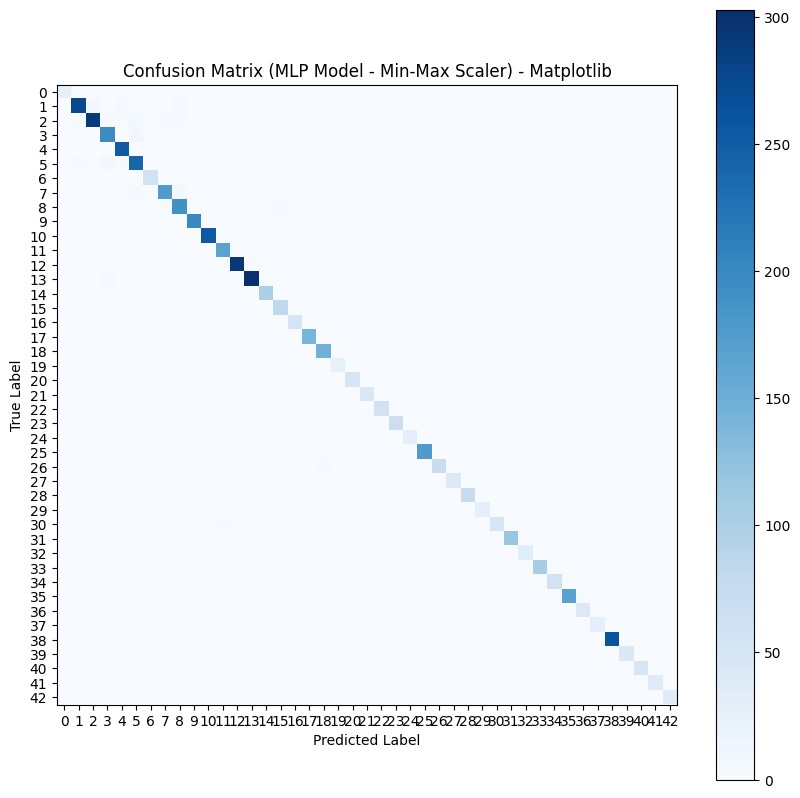

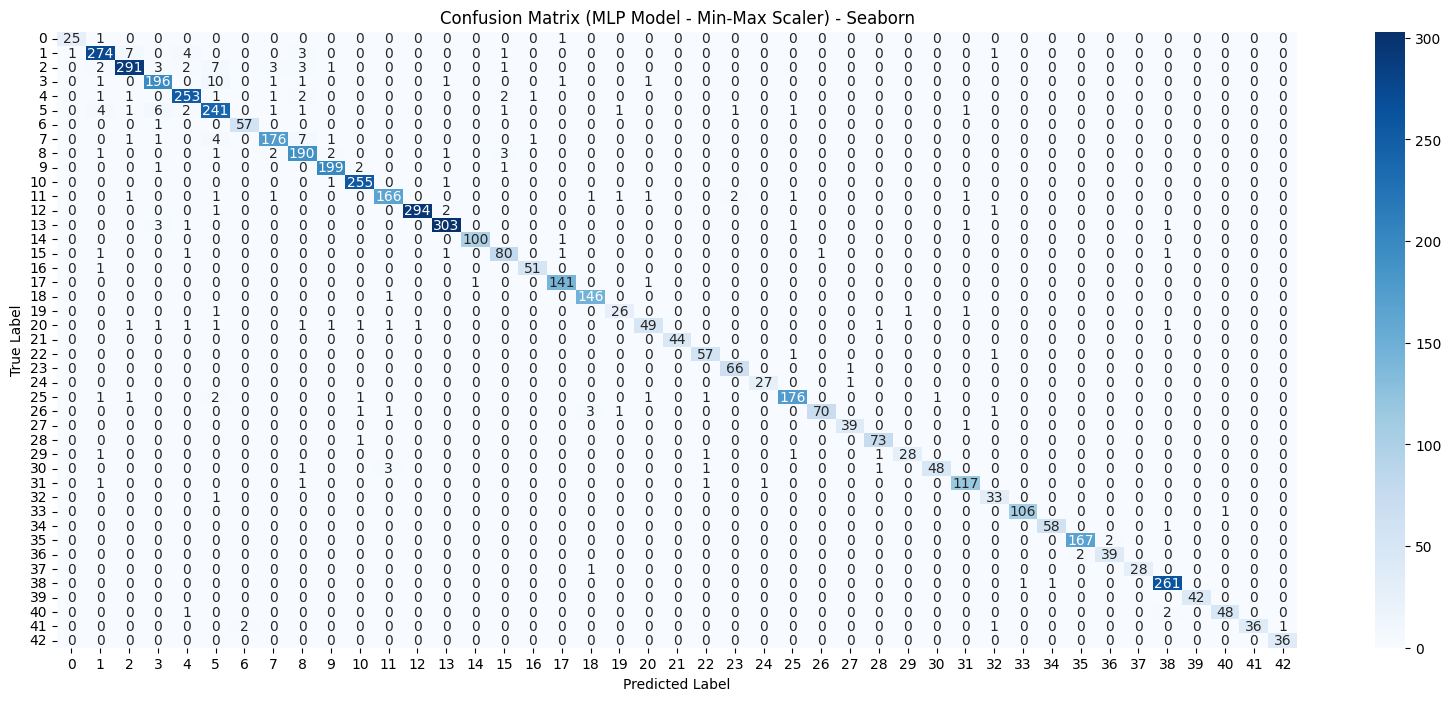

In [ ]:
# MLP Modeli Min-Max Scaler icin Confusion Matrix (Matplotlib)
cm_minmax = confusion_matrix(y_test, y_pred_minmax)
plt.figure(figsize=(10 , 10))
plt.imshow(cm_minmax, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (MLP Model - Min-Max Scaler) - Matplotlib')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# MLP Modeli Min-Max Scaler için Confusion Matrix (Seaborn)
plt.figure(figsize=(20, 8))
sns.heatmap(cm_minmax, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (MLP Model - Min-Max Scaler) - Seaborn')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

[[ 26   0   0 ...   0   0   0]
 [  2 280   4 ...   0   0   0]
 [  0   2 304 ...   0   0   0]
 ...
 [  0   0   0 ...  47   0   0]
 [  0   0   0 ...   0  37   0]
 [  0   0   0 ...   0   0  35]]


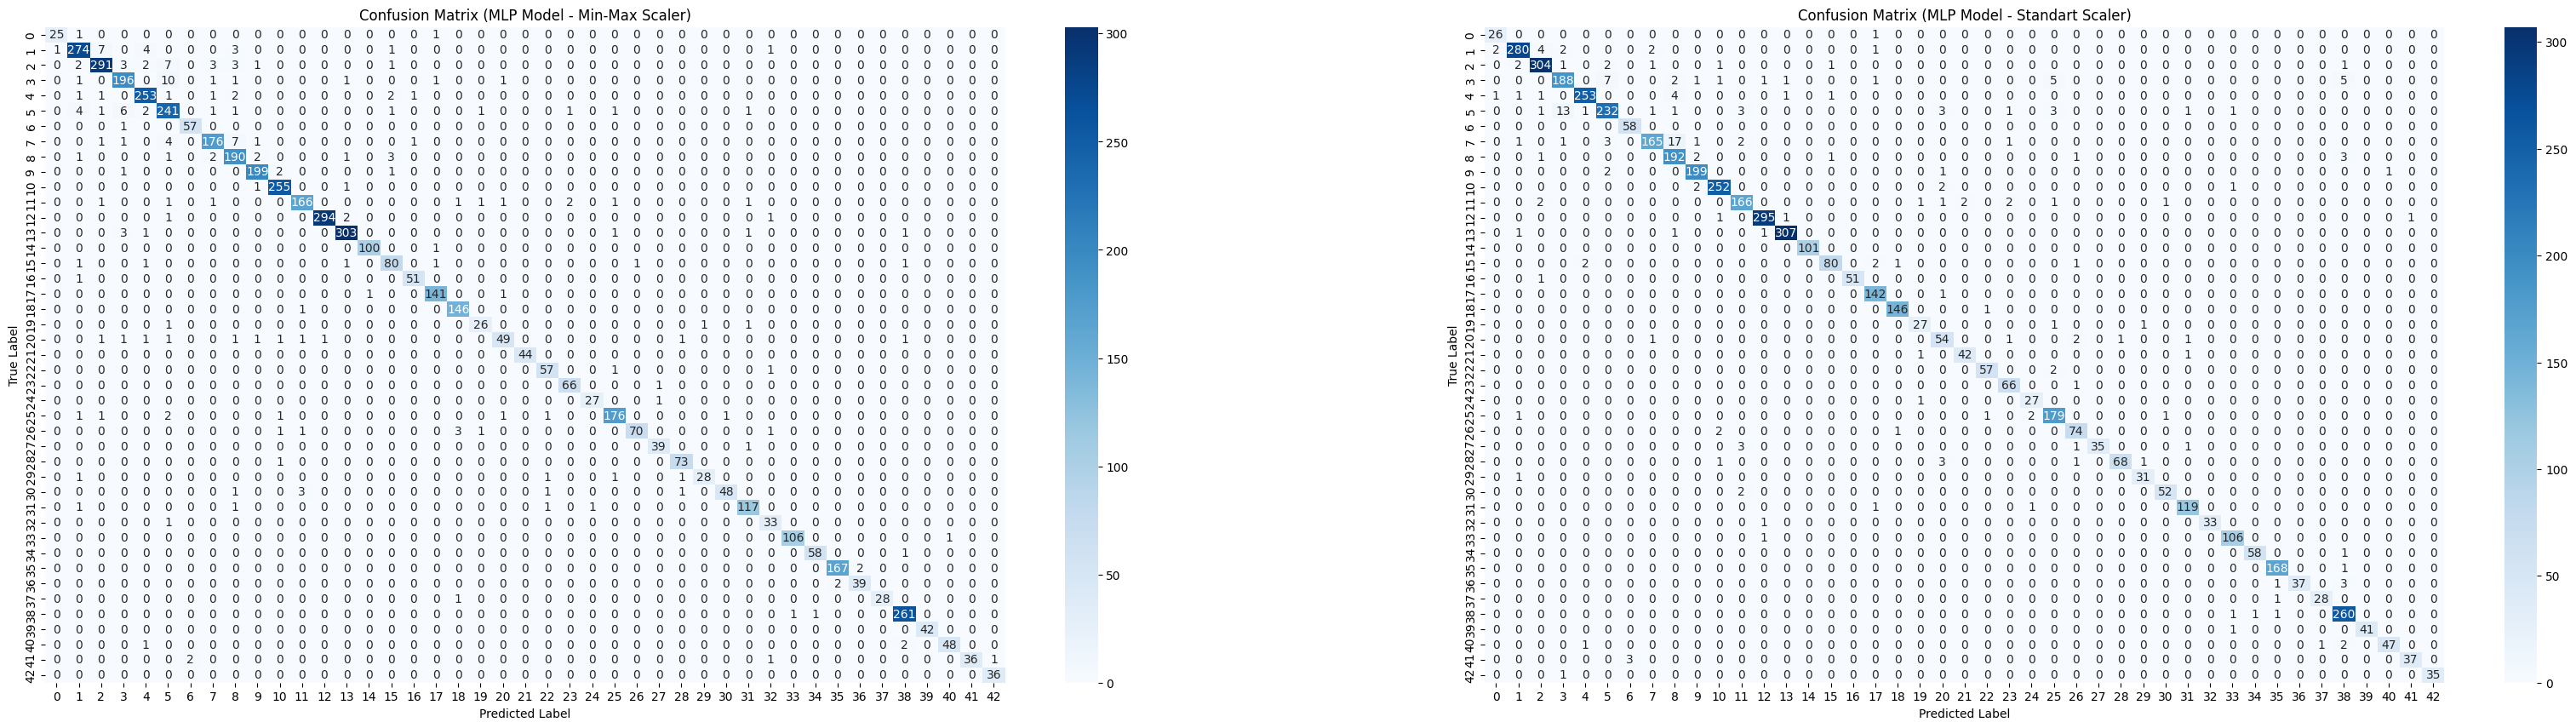

In [ ]:
# Iki confusion matrix'i karsilastirmak icin:
cm_standart = confusion_matrix(y_test, y_pred_standart) # Replace y_pred_standart with the actual variable name if different

print(cm_standart)

plt.figure(figsize=(40, 10))
plt.subplot(1, 2, 1)
sns.heatmap(cm_minmax, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (MLP Model - Min-Max Scaler)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 2, 2)
sns.heatmap(cm_standart, annot=True, fmt='d', cmap='Blues') # Now cm_standart is defined and can be used
plt.title('Confusion Matrix (MLP Model - Standart Scaler)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

##### 4.1. MLP Modeli Standart Scaler icin Confusion Matrix

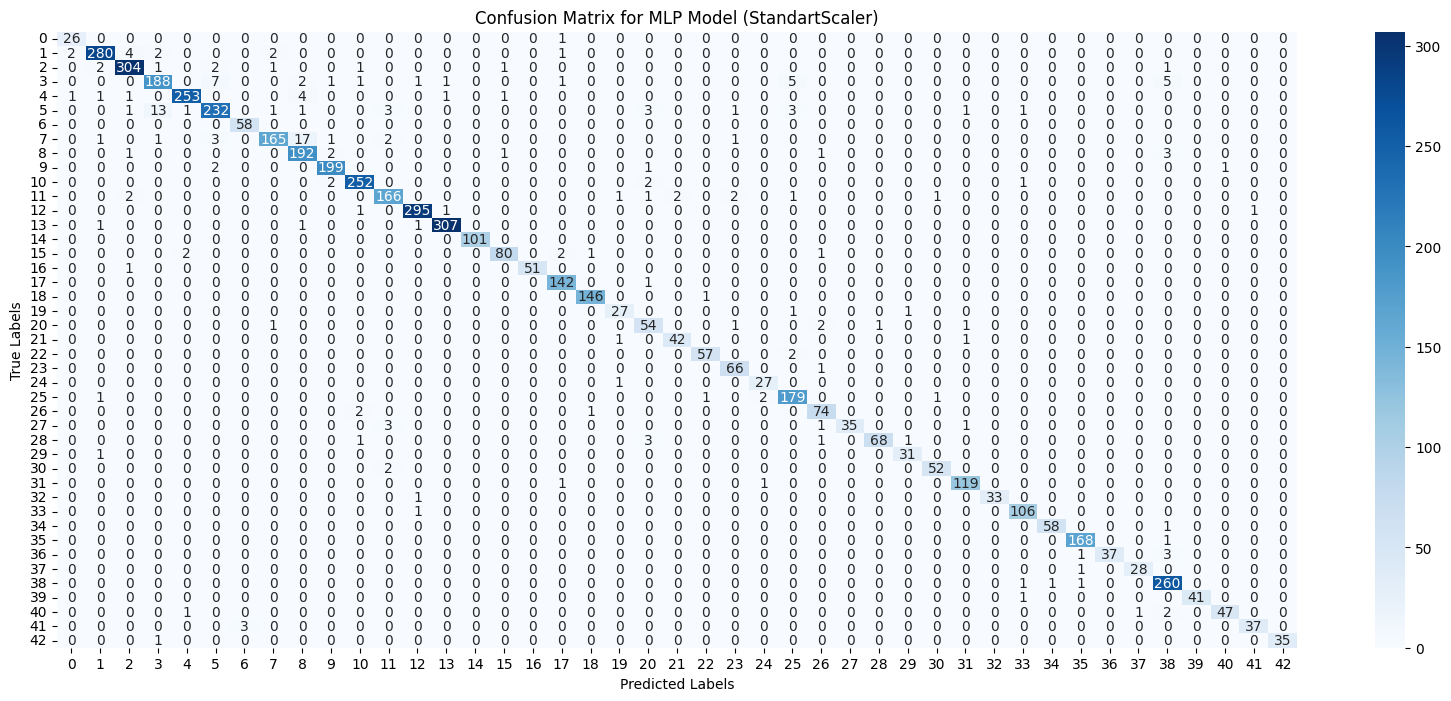

In [ ]:
# MLP Model (StandartScaler) icin Confusion Matrix
cm_standart = confusion_matrix(y_test, y_pred_standart)

plt.figure(figsize=(20, 8))
sns.heatmap(cm_standart, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for MLP Model (StandartScaler)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

##### 4.1. RBF Modeli Min-Max Scaler icin Confusion Matrix

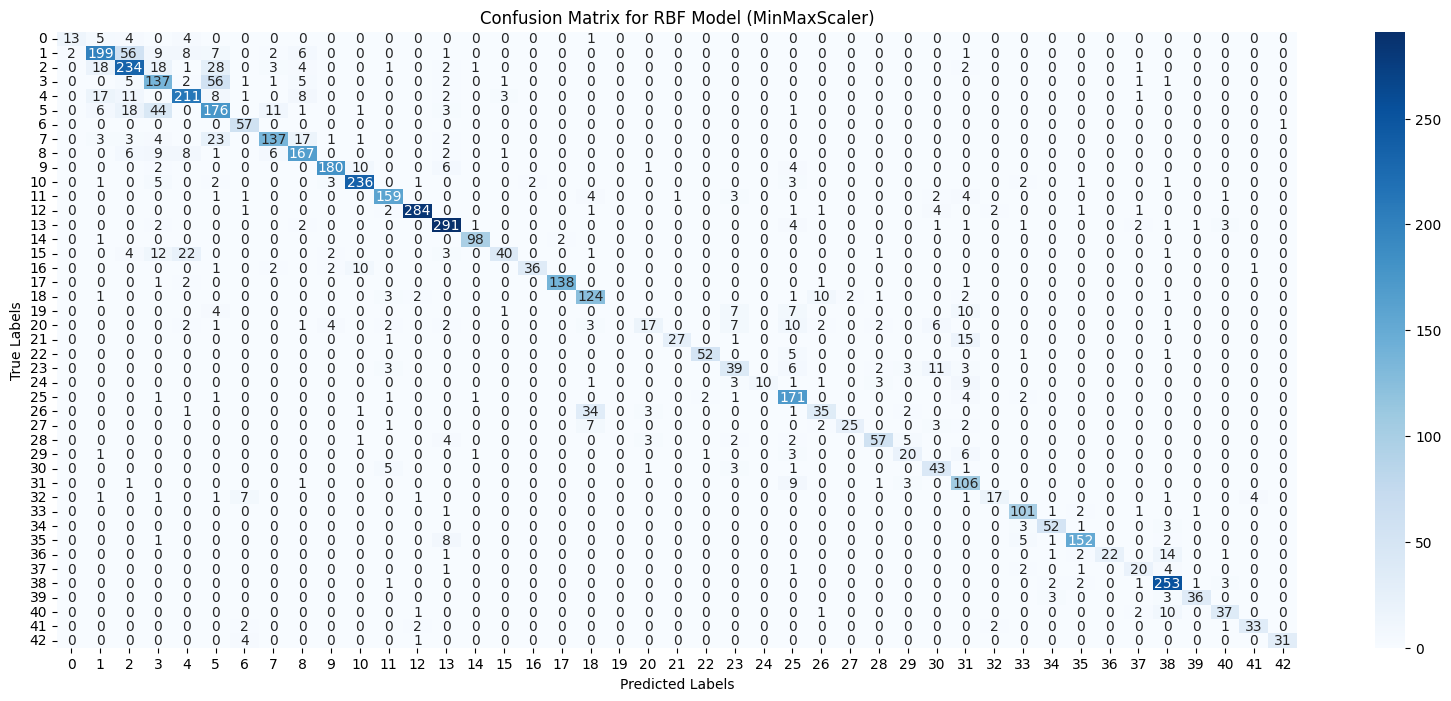

In [ ]:
# RBF Model (MinMaxScaler) icin Confusion Matrix
cm_rbf_minmax = confusion_matrix(y_test, y_pred_rbf)

plt.figure(figsize=(20, 8))
sns.heatmap(cm_rbf_minmax, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for RBF Model (MinMaxScaler)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

##### 4.1. RBF Modeli Standart Scaler icin Confusion Matrix

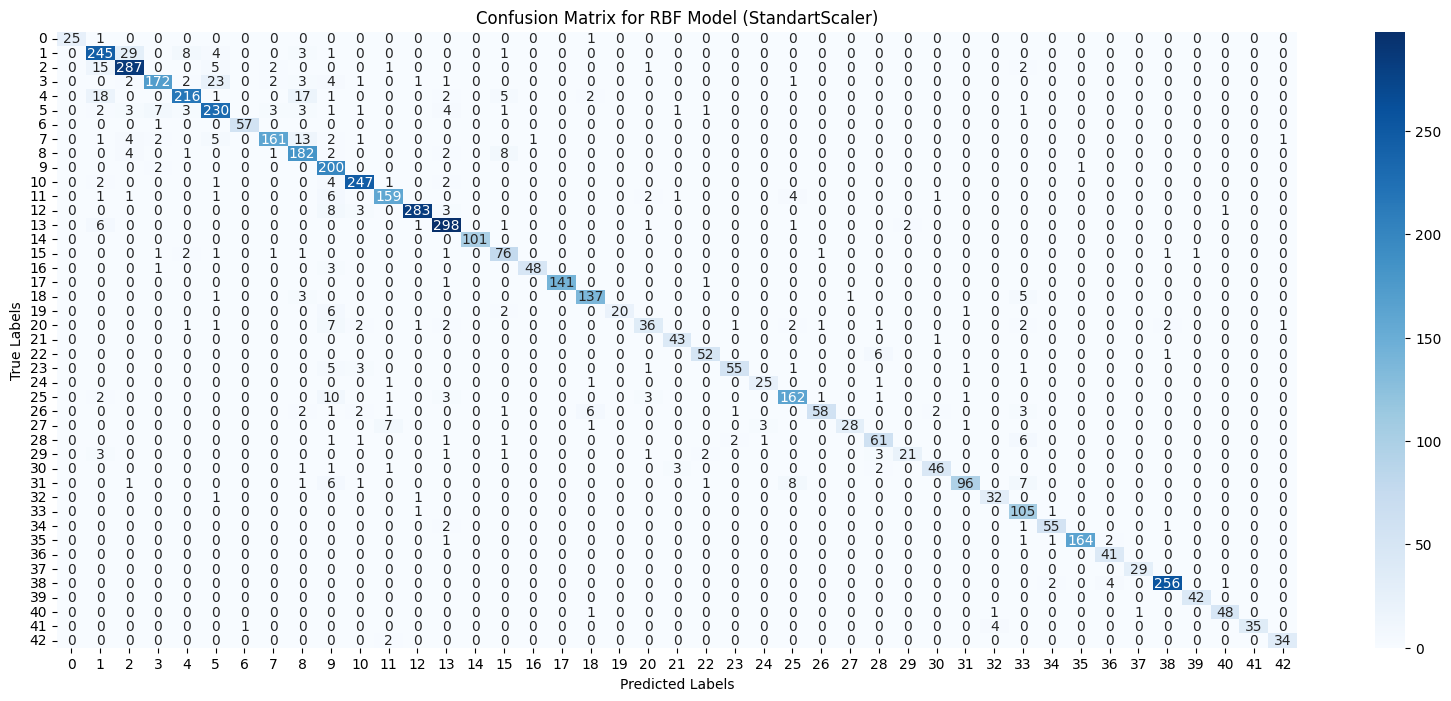

In [ ]:
# RBF Model (StandartScaler) icin Confusion Matrix
cm_rbf_standart = confusion_matrix(y_test, y_pred_rbf_standart)

plt.figure(figsize=(20, 8))
sns.heatmap(cm_rbf_standart, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for RBF Model (StandartScaler)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### 4.2. Performans Metrikleri

##### 4.2. MLP Modeli Standart Scaler icin Performans Metrikleri

In [ ]:
# StandartScaler ile egitilmis MLP modelinin sonuclarini degerlendirme
print("StandartScaler ile MLP Model Sonuçları:")
print(classification_report(y_test, y_pred_standart))


StandartScaler ile MLP Model Sonuçları:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        27
           1       0.98      0.96      0.97       291
           2       0.97      0.97      0.97       313
           3       0.91      0.89      0.90       212
           4       0.98      0.97      0.97       262
           5       0.94      0.89      0.92       261
           6       0.95      1.00      0.97        58
           7       0.97      0.86      0.91       191
           8       0.88      0.96      0.92       200
           9       0.97      0.98      0.98       203
          10       0.98      0.98      0.98       257
          11       0.94      0.94      0.94       176
          12       0.99      0.99      0.99       298
          13       0.99      0.99      0.99       310
          14       1.00      1.00      1.00       101
          15       0.96      0.93      0.95        86
          16       1.00      0.98      0.

##### 4.2. MLP Modeli Min-Max Scaler icin Performans Metrikleri

In [ ]:
# Min-Max Scaler ile egitilmis MLP modelinin sonuclarini degerlendirme
print("MinMaxScaler ile MLP Model Sonuçları:")
print(classification_report(y_test, y_pred_minmax))

MinMaxScaler ile MLP Model Sonuçları:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        27
           1       0.95      0.94      0.94       291
           2       0.96      0.93      0.94       313
           3       0.92      0.92      0.92       212
           4       0.95      0.97      0.96       262
           5       0.89      0.92      0.91       261
           6       0.97      0.98      0.97        58
           7       0.95      0.92      0.94       191
           8       0.90      0.95      0.93       200
           9       0.97      0.98      0.98       203
          10       0.98      0.99      0.98       257
          11       0.97      0.94      0.95       176
          12       1.00      0.99      0.99       298
          13       0.98      0.98      0.98       310
          14       0.99      0.99      0.99       101
          15       0.90      0.93      0.91        86
          16       0.96      0.98      0.97

##### 4.2. RBF Modeli Standart Scaler icin Performans Metrikleri

In [ ]:
# StandartScaler ile egitilmis RBF modelinin performans metriklerini hesaplama
print("RBF Model Sonuçları (StandartScaler):")
print(classification_report(y_test, y_pred_rbf_standart))

RBF Model Sonuçları (StandartScaler):
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        27
           1       0.83      0.84      0.83       291
           2       0.87      0.92      0.89       313
           3       0.92      0.81      0.86       212
           4       0.93      0.82      0.87       262
           5       0.84      0.88      0.86       261
           6       0.98      0.98      0.98        58
           7       0.95      0.84      0.89       191
           8       0.79      0.91      0.85       200
           9       0.74      0.99      0.85       203
          10       0.94      0.96      0.95       257
          11       0.91      0.90      0.91       176
          12       0.98      0.95      0.97       298
          13       0.92      0.96      0.94       310
          14       1.00      1.00      1.00       101
          15       0.78      0.88      0.83        86
          16       0.98      0.92      0.95

##### 4.2. RBF Modeli Min-Max Scaler icin Performans Metrikleri

In [ ]:
# MinMaxScaler ile egitilmis RBF modelinin performans metriklerini hesaplama
print("RBF Model Sonuçları (MinMaxScaler):")
print(classification_report(y_test, y_pred_rbf))

RBF Model Sonuçları (MinMaxScaler):
              precision    recall  f1-score   support

           0       0.87      0.48      0.62        27
           1       0.79      0.68      0.73       291
           2       0.68      0.75      0.71       313
           3       0.56      0.65      0.60       212
           4       0.81      0.81      0.81       262
           5       0.57      0.67      0.62       261
           6       0.77      0.98      0.86        58
           7       0.85      0.72      0.78       191
           8       0.79      0.83      0.81       200
           9       0.94      0.89      0.91       203
          10       0.91      0.92      0.91       257
          11       0.89      0.90      0.90       176
          12       0.97      0.95      0.96       298
          13       0.88      0.94      0.91       310
          14       0.96      0.97      0.97       101
          15       0.87      0.47      0.61        86
          16       0.95      0.69      0.80  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 5. Hiperparametre Denemeleri ve Sonuçları Karşılaştırma

##### 5.1. Hiperparametre Denemeleri

In [28]:
mlp_param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
}


# GridSearchCV ile MLP
mlp_grid_search = GridSearchCV(MLPClassifier(max_iter=100, random_state=21, verbose=0, tol=1e-8),
                              mlp_param_grid, cv=3, n_jobs=-1)
mlp_grid_search.fit(X_train_MinMaxScaler, y_train)

print("MLP (GridSearchCV) en iyi parametreleri:", mlp_grid_search.best_params_)
print("MLP (GridSearchCV) en iyi sonuc:", mlp_grid_search.best_score_)

# RandomizedSearchCV ile MLP
mlp_random_search = RandomizedSearchCV(MLPClassifier(max_iter=100, random_state=21, verbose=0, tol=1e-8),
                                      mlp_param_grid, n_iter=10, cv=3, n_jobs=-1)
mlp_random_search.fit(X_train_MinMaxScaler, y_train)

print("MLP (RandomizedSearchCV) en iyi parametreleri:", mlp_random_search.best_params_)
print("MLP (RandomizedSearchCV) en iyi sonuc:", mlp_random_search.best_score_)


# GridSearchCV ile RBF
rbf_grid_search = GridSearchCV(MLPClassifier(max_iter=100, random_state=21, verbose=0, tol=1e-8),
                              mlp_param_grid, cv=3, n_jobs=-1)
rbf_grid_search.fit(X_train_MinMaxScaler, y_train)

print("RBF (GridSearchCV) en iyi parametreleri:", rbf_grid_search.best_params_)
print("RBF (GridSearchCV) en iyi sonuc:", rbf_grid_search.best_score_)

# RandomizedSearchCV ile RBF
rbf_random_search = RandomizedSearchCV(MLPClassifier(max_iter=100, random_state=21, verbose=0, tol=1e-8),
                                      mlp_param_grid, n_iter=10, cv=3, n_jobs=-1)
rbf_random_search.fit(X_train_MinMaxScaler, y_train)

print("RBF (RandomizedSearchCV) en iyi parametreleri:", rbf_random_search.best_params_)
print("RBF (RandomizedSearchCV) en iyi sonuc:", rbf_random_search.best_score_)

MLP (GridSearchCV) en iyi parametreleri: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
MLP (GridSearchCV) en iyi sonuc: 0.9634009009009009
MLP (RandomizedSearchCV) en iyi parametreleri: {'solver': 'adam', 'hidden_layer_sizes': (100, 50), 'alpha': 0.0001, 'activation': 'tanh'}
MLP (RandomizedSearchCV) en iyi sonuc: 0.9549080330330332
RBF (GridSearchCV) en iyi parametreleri: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
RBF (GridSearchCV) en iyi sonuc: 0.9634009009009009
RBF (RandomizedSearchCV) en iyi parametreleri: {'solver': 'adam', 'hidden_layer_sizes': (100,), 'alpha': 0.001, 'activation': 'tanh'}
RBF (RandomizedSearchCV) en iyi sonuc: 0.9539695945945946


Bu çalışmada, GridSearchCV ve RandomizedSearchCV yöntemleriyle optimize edilen MLP (Multilayer Perceptron) ve RBF (Radial Basis Function) modellerinin performansları karşılaştırılmıştır. Sonuçlar, iki yöntem arasında farklılıklar olduğunu ve her birinin farklı avantajlar sunduğunu göstermektedir.

**GridSearchCV ile Optimize Edilen Modeller**  
GridSearchCV yöntemi, hiperparametre kombinasyonlarını sistematik olarak taramış ve hem MLP hem de RBF modelleri için aynı optimal parametre setini belirlemiştir. Bu parametreler, `'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'solver': 'adam'` şeklindedir. Her iki model de bu yapılandırma ile %96.34 doğruluk oranına ulaşmıştır. GridSearchCV'nin sonuçları, sistematik tarama yöntemi sayesinde oldukça yüksek doğruluk oranına ve tutarlı sonuçlara ulaşılabileceğini göstermektedir. Bu sonuçlar, özellikle büyük veri setlerinde GridSearchCV'nin güçlü bir yöntem olduğunu ortaya koymaktadır.

**RandomizedSearchCV ile Optimize Edilen Modeller**  
RandomizedSearchCV yöntemi, daha geniş bir parametre uzayı içerisinde rastgele seçilen kombinasyonları değerlendirerek optimal parametreleri belirlemiştir. MLP modeli için `'hidden_layer_sizes': (100, 50), 'alpha': 0.0001, 'activation': 'tanh', 'solver': 'adam'` parametreleri ile %95.49 doğruluk oranına ulaşılmıştır. RBF modeli ise daha basit bir yapı olan `'hidden_layer_sizes': (100,), 'alpha': 0.001, 'activation': 'tanh', 'solver': 'adam'` parametreleriyle %95.40 doğruluk oranı sağlamıştır. RandomizedSearchCV, GridSearchCV’ye göre daha az hesaplama gücü gerektirmesine rağmen %95'in üzerinde doğruluk oranlarıyla başarılı sonuçlar elde etmiştir.

**MLP ve RBF Modellerinin Karşılaştırması**  
GridSearchCV sonuçlarında, MLP ve RBF modelleri aynı parametre seti ile %96.34 doğruluk oranına ulaşmıştır. Bu durum, GridSearchCV’nin sistematik tarama yeteneği ile optimal çözüme ulaştığını göstermektedir. RandomizedSearchCV sonuçlarına bakıldığında, MLP modeli %95.49 doğruluk oranı ile RBF modeline (%95.40) göre biraz daha yüksek bir performans göstermiştir. Bunun temel nedeni, MLP modelinin daha karmaşık bir yapı (iki gizli katman) seçmiş olmasıdır. Ancak bu fark oldukça küçüktür ve her iki model de başarılı sonuçlar sunmaktadır.

**Genel Değerlendirme**  
Sonuçlar, GridSearchCV’nin sistematik yapısı sayesinde daha yüksek doğruluk oranları sağladığını ve her iki modelde de %96.34 gibi güçlü bir başarıya ulaştığını göstermektedir. RandomizedSearchCV ise daha hızlı ve hesaplama açısından daha verimli bir yöntem olarak dikkat çekmektedir ve %95'in üzerinde doğruluk oranlarıyla tatmin edici sonuçlar elde edilmiştir. MLP ve RBF modelleri arasında doğruluk açısından belirgin bir fark olmamakla birlikte, MLP modeli daha karmaşık yapılarla çalışarak bir miktar daha yüksek doğruluk sağlayabilmiştir.

Sonuç olarak, yüksek doğruluk ve tutarlılık arayan kullanıcılar için GridSearchCV ile optimize edilen modeller önerilebilir. Daha hızlı sonuçlar almak ve hesaplama maliyetini düşürmek isteyen kullanıcılar için ise RandomizedSearchCV uygun bir seçenek olabilir. MLP ve RBF modelleri arasında performans farkı minimal düzeyde olduğundan, uygulama ihtiyaçlarına göre seçim yapılabilir.